This notebook is for exploring various kmeans and GMM results based on a variety of inputs, including raw band stacks, shadow and building masks, etc. 

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
import sys
import pickle
from glob import glob
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Establish path for modules
sys.path.insert(0, '..\\modules\\')

# Import modules with custom functions
import calc_array_mask_test
import morph_indices

# Set font sizes for plots
plt.rc('figure', titlesize=24)
plt.rc('axes', titlesize=16)

In [3]:
# For windows users
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

### Note: update "aoi" parameter and band_path with directory name for imagery of interest

In [4]:
# Identify area of interest (aoi), set directories for inputs and outputs
aoi = "beira_ps"

# Define paths to bands
band_path = '..\\data\\'+aoi+"\\"
outputs_path= os.path.join(band_path, "outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
try:
    os.makedirs(kmeans_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")
# # band_path = os.path.join("dg-data", aoi +"\\")
# try:
#     os.makedirs(band_path)
# except FileExistsError:
#     print("band_path directory already exists!")



# # Checks for existing outputs directory for raster files
# outputs_path= os.path.join(band_path, "outputs\\raster_files\\")
# try:
#     os.makedirs(outputs_path)
# except FileExistsError:
#     print("outputs_path directory already exists!")
# # outputs_path = os.path.join(band_path, "outputs\\")

# kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
# try:
#     os.makedirs(kmeans_outputs_path)
# except FileExistsError:
#     print("band_path directory already exists!")

band_path directory already exists!


In [5]:
# Create raster stack of all bands
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [6]:
# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
    masks_out_meta = src.meta.copy()
    stack_out_meta = src.meta.copy()
    files_out_meta_test = src.meta.copy()

In [7]:
# Update files_out_meta for writing out single files
files_out_meta['count']=1
files_out_meta_test['count']=1
files_out_meta_test['nodata']=-99999
# _test NDVI, NDWI, MSI files saved without using 'nodata' = -9999
# files_out_meta['nodata']=-9999

# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1

# Update stack_out_meta for writing out cloud masked band stack
stack_out_meta['nodata']=-99999

In [8]:
# # Scale raster stack to surface reflectance values (should be between 0 and 1)
# all_bands_scaled = all_bands_stack/10000

In [9]:
# Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(all_bands_scaled.ravel());

In [10]:
# # Read in scaled bands
# coastal_scaled = all_bands_scaled[0]
# blue_scaled = all_bands_scaled[1]
# green_scaled = all_bands_scaled[2]
# yellow_scaled = all_bands_scaled[3]
# red_scaled = all_bands_scaled[4]
# rededge_scaled = all_bands_scaled[5]
# nearir1_scaled = all_bands_scaled[6]
# nearir2_scaled = all_bands_scaled[7]

In [11]:
# with rio.open(outputs_path+'raw_coastal_scaled.tif', 'w', **files_out_meta) as dst:
#     dst.write(coastal_scaled,1)

In [13]:
# # Read in indices
# dark_path = outputs_path+'dark.tif'
# with rio.open(dark_path) as src:
#     dark = src.read()
# mbi_path = outputs_path+'mbi.tif'
# with rio.open(mbi_path) as src:
#     mbi = src.read()
# msi_path = outputs_path+'msi.tif'
# with rio.open(msi_path) as src:
#     msi = src.read()
# ndvi_path = outputs_path+'ndvi.tif'
# with rio.open(ndvi_path) as src:
#     ndvi = src.read()
# ndwi_path = outputs_path+'ndwi_yellow.tif'
# with rio.open(ndwi_path) as src:
#     ndwi = src.read()

In [ ]:
# stack = [dark,mbi,msi,ndvi,ndwi]
# index_stack = np.vstack(stack)

In [ ]:
# # Read in indices
# building_mask_path = outputs_path+'building_mask.tif'
# with rio.open(building_mask_path) as src:
#     building_mask = src.read()
# shadow_mask_path = outputs_path+'msi_shadow_mask.tif'
# with rio.open(shadow_mask_path) as src:
#     shadow_mask = src.read()
# vegetation_mask_path = outputs_path+'vegetation_mask.tif'
# with rio.open(vegetation_mask_path) as src:
#     vegetation_mask = src.read()
# flood_mask_path = outputs_path+'flood_combo_mask.tif'
# with rio.open(flood_mask_path) as src:
#     flood_mask = src.read()

In [ ]:
# stack = [building_mask, shadow_mask, vegetation_mask, flood_mask]
# mask_stack = np.vstack(stack)

In [ ]:
# stack_all = [all_bands_stack, mask_stack]
# band_mask_stack = np.vstack(stack_all)

# Exploring k-means results

In [8]:
# Define k-means classifier
from sklearn.cluster import KMeans
from scipy.ndimage import generic_filter
# Define classifier
nclass = 8
clf_kmeans = KMeans(n_clusters=nclass, random_state=10)
pickle.dump(clf_kmeans,open(kmeans_outputs_path+'pickle_kmeans', 'wb'))

In [15]:
# # Run k-means on the mask plus 8 band raster stack
# band_mask_stack_im = np.rollaxis(band_mask_stack, 0, 3)
# X_band_mask_stack = band_mask_stack_im.reshape(-1,4)# Fit the KMeans classifier to the 8-band raster stack
# predictedClass_band_mask_stack = clf_kmeans.fit_predict(X_band_mask_stack, y=None)
# predictedClass_band_mask_stack += 1

# # Plot the result
# fig, ax = plt.subplots(figsize = (20,20))
# pred_data_band_mask_stack = predictedClass_band_mask_stack.reshape(band_mask_stack_im.shape[:2])
# ax.imshow(pred_data_band_mask_stack)
# plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
# plt.show()

# # pred_data_shadow_free = pred_data_shadow_free[np.newaxis,:]
# with rio.open(kmeans_outputs_path+'kmeans_band_mask_stack.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_band_mask_stack.astype('float32'),1)

In [16]:
# # Run k-means on the mask raster stack
# mask_stack_im = np.rollaxis(mask_stack, 0, 3)
# X_mask_stack = mask_stack_im.reshape(-1,4)# Fit the KMeans classifier to the 8-band raster stack
# predictedClass_mask_stack = clf_kmeans.fit_predict(X_mask_stack, y=None)
# predictedClass_mask_stack += 1

# # Plot the result
# fig, ax = plt.subplots(figsize = (20,20))
# pred_data_mask_stack = predictedClass_mask_stack.reshape(mask_stack_im.shape[:2])
# ax.imshow(pred_data_mask_stack)
# plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
# plt.show()

# # pred_data_shadow_free = pred_data_shadow_free[np.newaxis,:]
# with rio.open(kmeans_outputs_path+'kmeans_mask_stack.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_mask_stack.astype('float32'),1)

In [17]:
# # Run k-means on the index raster stack
# index_stack_im = np.rollaxis(index_stack, 0, 3)
# X_index_stack = index_stack_im.reshape(-1,5)# Fit the KMeans classifier to the 8-band raster stack
# predictedClass_index_stack = clf_kmeans.fit_predict(X_index_stack, y=None)
# predictedClass_index_stack += 1

# # Plot the result
# fig, ax = plt.subplots(figsize = (20,20))
# pred_data_all_bands = predictedClass_index_stack.reshape(index_stack_im.shape[:2])
# ax.imshow(pred_data_index_stack)
# plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
# plt.show()

# # pred_data_shadow_free = pred_data_shadow_free[np.newaxis,:]
# with rio.open(kmeans_outputs_path+'kmeans_index_stack.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_index_stack.astype('float32'),1)

In [18]:
# Reshape 8 band raster stack for input to k-means
all_bands_im = np.rollaxis(all_bands_stack, 0, 3)
X_all_bands_stack = all_bands_im.reshape(-1,8)

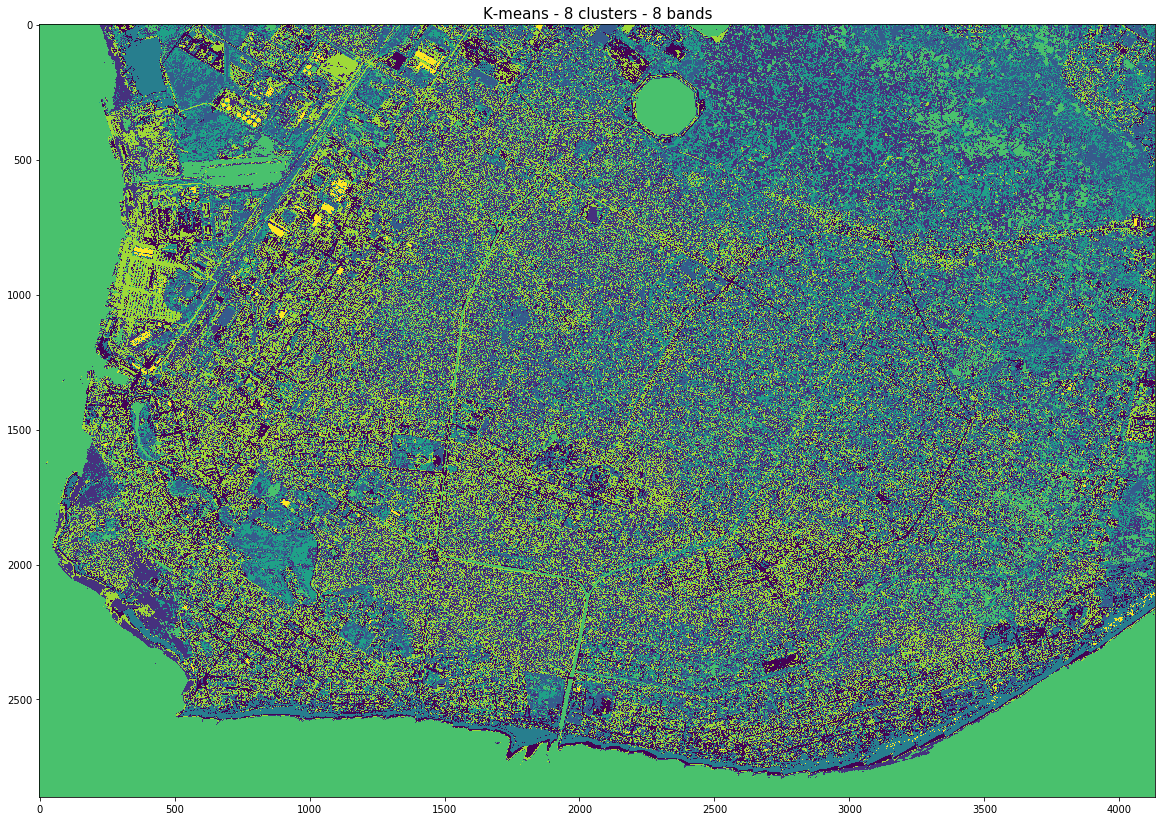

In [19]:
# Run k-means on the 8-band raster stack
all_bands_im = np.rollaxis(all_bands_stack, 0, 3)
X_all_bands_stack = all_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_all_bands = clf_kmeans.fit_predict(X_all_bands_stack, y=None)
predictedClass_all_bands += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_all_bands = predictedClass_all_bands.reshape(all_bands_im.shape[:2])
ax.imshow(pred_data_all_bands)
plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
plt.show()

# pred_data_shadow_free = pred_data_shadow_free[np.newaxis,:]
with rio.open(kmeans_outputs_path+'kmeans_all_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_all_bands.astype('float32'),1)

In [9]:
# Import raster stacks for k-means calculations
shadow_masked_band_stack_path = outputs_path+'shadow_masked_stack.tif'
with rio.open(shadow_masked_band_stack_path) as src:
    all_bands_shadow_free = src.read()
    all_bands_shadow_free_meta = src.meta

cloud_masked_band_stack_path = outputs_path+'all_bands_cl_free_beira_ps.tif'
with rio.open(cloud_masked_band_stack_path) as src:
    all_bands_cl_free = src.read()
    all_bands_cl_free_meta = src.meta

msi_path = outputs_path+'msi.tif'
with rio.open(msi_path) as src:
    msi = src.read()
    msi_meta = src.meta
    
shadow_mask_path = outputs_path+'msi_shadow_mask.tif'
with rio.open(shadow_mask_path) as src:
    shadow_mask = src.read()
    shadow_mask_meta = src.meta
    
building_mask_path = outputs_path+'building_mask.tif'
with rio.open(building_mask_path) as src:
    building_mask = src.read()
    building_mask_meta = src.meta
    
shadow_mask_apply = np.squeeze(shadow_mask)


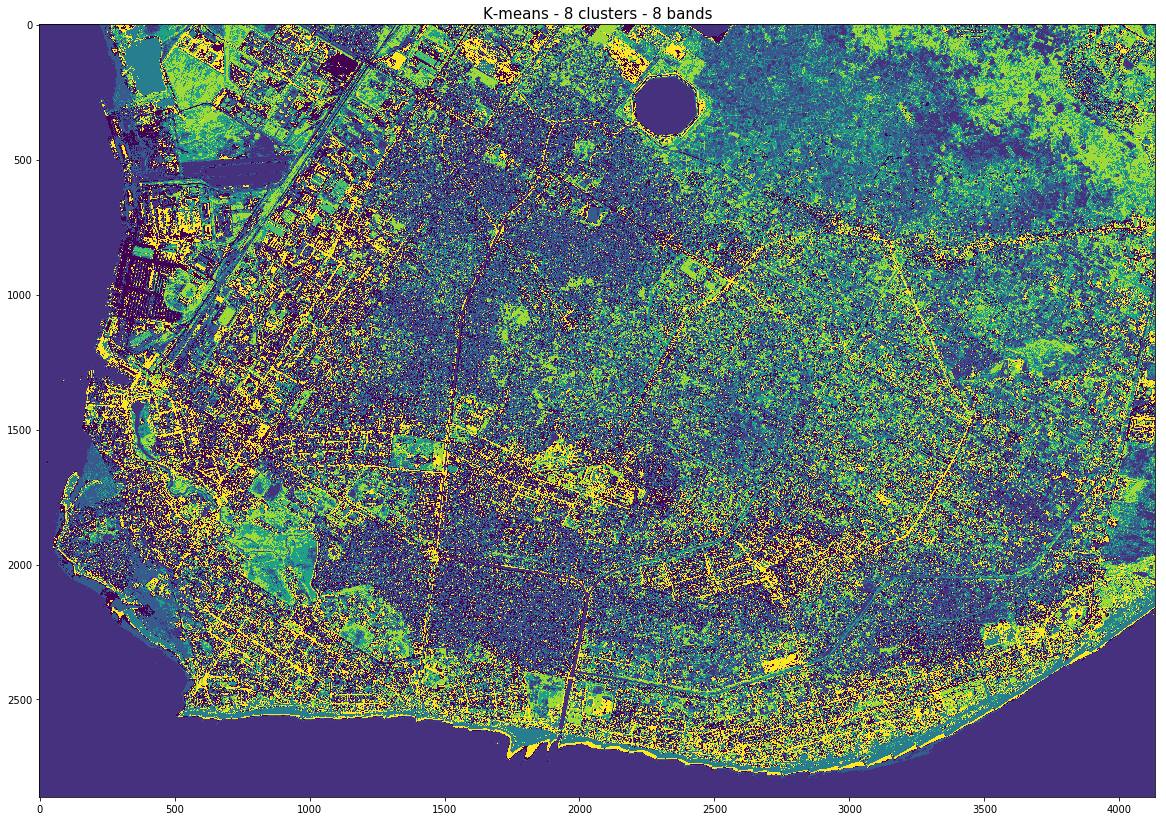

In [23]:
# Run k-means on all_bands_shadow_free, plot and write out result
# Reshape array 
shadow_free_bands_im = np.rollaxis(all_bands_shadow_free, 0, 3)
X_shadow_free = shadow_free_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free = clf_kmeans.fit_predict(X_shadow_free, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_shadow_free += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_shadow_free = predictedClass_shadow_free.reshape(shadow_free_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
plt.show()

# pred_data_shadow_free = pred_data_shadow_free[np.newaxis,:]
with rio.open(kmeans_outputs_path+'kmeans_shadow_free.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free.astype('float32'),1)

In [11]:
# # Apply shadow mask to resulting kmeans clusters from shadow masked band stack
# kmeans_shadow_mask = calc_array_mask_test.apply_mask(mask_array = shadow_mask_apply, raster_input = pred_data_shadow_free)
# kmeans_shadow_mask_plot = np.squeeze(kmeans_shadow_mask)
# fig, ax = plt.subplots(figsize = (40,40))
# im = ax.imshow(kmeans_shadow_mask_plot)
# # values = np.unique(kmeans_shadow_mask_plot)
# # cat_names = ["1","2","3","4","5","6","7","8"]
# # ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters Shadow Masked 8 bands")
# # ax[1].imshow(all_bands_stack)
# plt.show()

# # kmeans_shadow_mask_plot = kmeans_shadow_mask_plot[np.newaxis,:]
# # files_out_meta['count'] = 1
# with rio.open(outputs_path+'kmeans_shadow_free_shadow_mask_applied_after.tif', 'w', **files_out_meta) as dst:
#     dst.write(kmeans_shadow_mask_plot.astype('float32'),1)

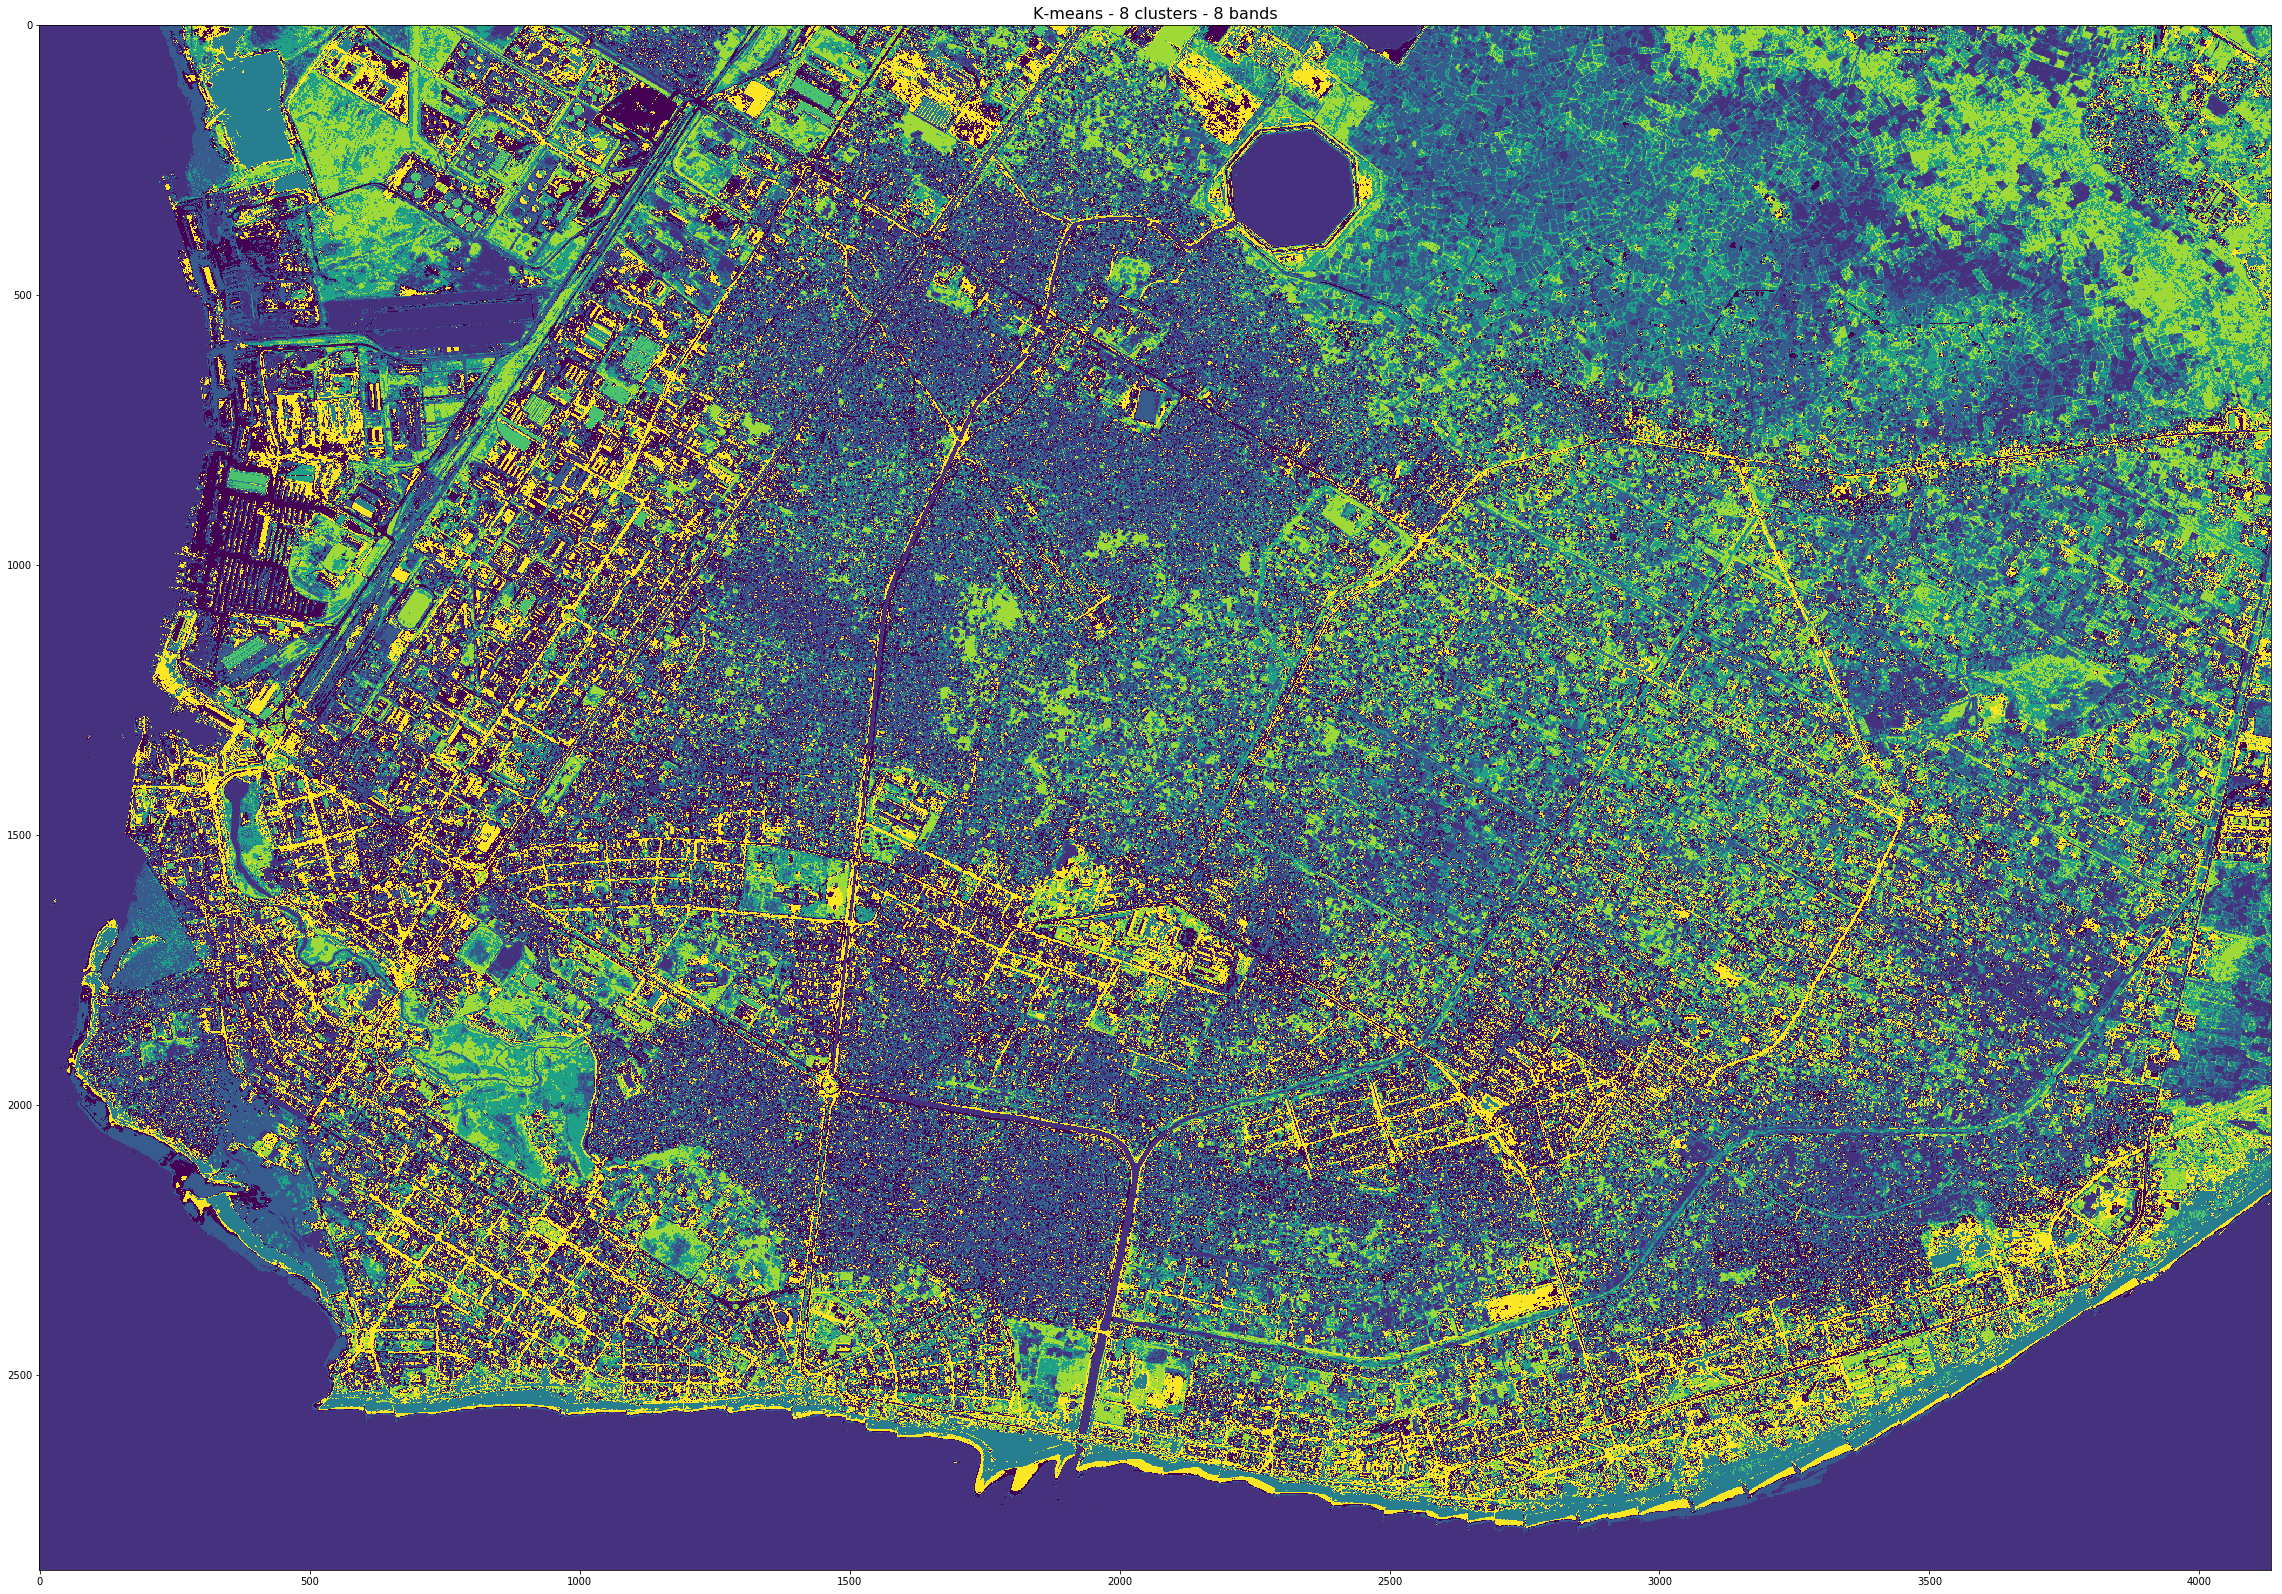

In [12]:
# Run k-means on cloud masked stack, plot and write out result
# Reshape array 
cloud_free_bands_im = np.rollaxis(all_bands_cl_free, 0, 3)
X_cloud_free = cloud_free_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free = clf_kmeans.fit_predict(X_cloud_free, y=None)
predictedClass_cloud_free += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_cloud_free = predictedClass_cloud_free.reshape(cloud_free_bands_im.shape[:2])
im = ax.imshow(pred_data_cloud_free)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_cloud_free = pred_data_cloud_free[np.newaxis,:]
with rio.open(kmeans_outputs_path+'kmeans_cl_free.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_cloud_free.astype('float32'),1)

In [13]:
# Create and write out stacks combining shadow masked band stack and MSI and shadow mask
# msi_stack = msi#[np.newaxis,:]
all_bands_shadow_free_msi = np.vstack((all_bands_shadow_free,msi))
# shadow_mask_stack = shadow_mask#[np.newaxis,:]
all_bands_shadow_free_shadow_mask = np.vstack((all_bands_shadow_free,shadow_mask))
all_bands_cl_free_msi = np.vstack((all_bands_cl_free,msi))
all_bands_cl_free_shadow_mask = np.vstack((all_bands_cl_free,shadow_mask))

# shadow_mask_cleaned_stack = shadow_mask_cleaned[np.newaxis,:]
# all_bands_shadow_free_shadow_mask_cleaned = np.vstack((all_bands_shadow_free,shadow_mask_cleaned_stack))

# smoothed_msi_stack = smoothed_msi[np.newaxis,:]
# all_bands_shadow_free_smoothed_msi = np.vstack((all_bands_shadow_free,smoothed_msi_stack))

# kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
# try:
#     os.makedirs(kmeans_outputs_path)
# except FileExistsError:
#     print("band_path directory already exists!")

#Write out stacks for kmeans
stack_out_meta['count']=9
with rio.open(kmeans_outputs_path+'all_bands_shadow_free_msi_stack.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_shadow_free_msi.astype('float32'))
with rio.open(kmeans_outputs_path+'all_bands_shadow_free_shadow_mask_stack.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_shadow_free_shadow_mask.astype('float32'))
with rio.open(kmeans_outputs_path+'all_bands_cl_free_msi_stack.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_cl_free_msi.astype('float32'))
with rio.open(kmeans_outputs_path+'all_bands_cl_free_shadow_mask_stack.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_cl_free_shadow_mask.astype('float32'))
# with rio.open(kmeans_outputs_path+'all_bands_shadow_free_smoothed_msi_stack.tif', 'w', **stack_out_meta) as dst:
#     dst.write(all_bands_shadow_free_smoothed_msi.astype('float32'))

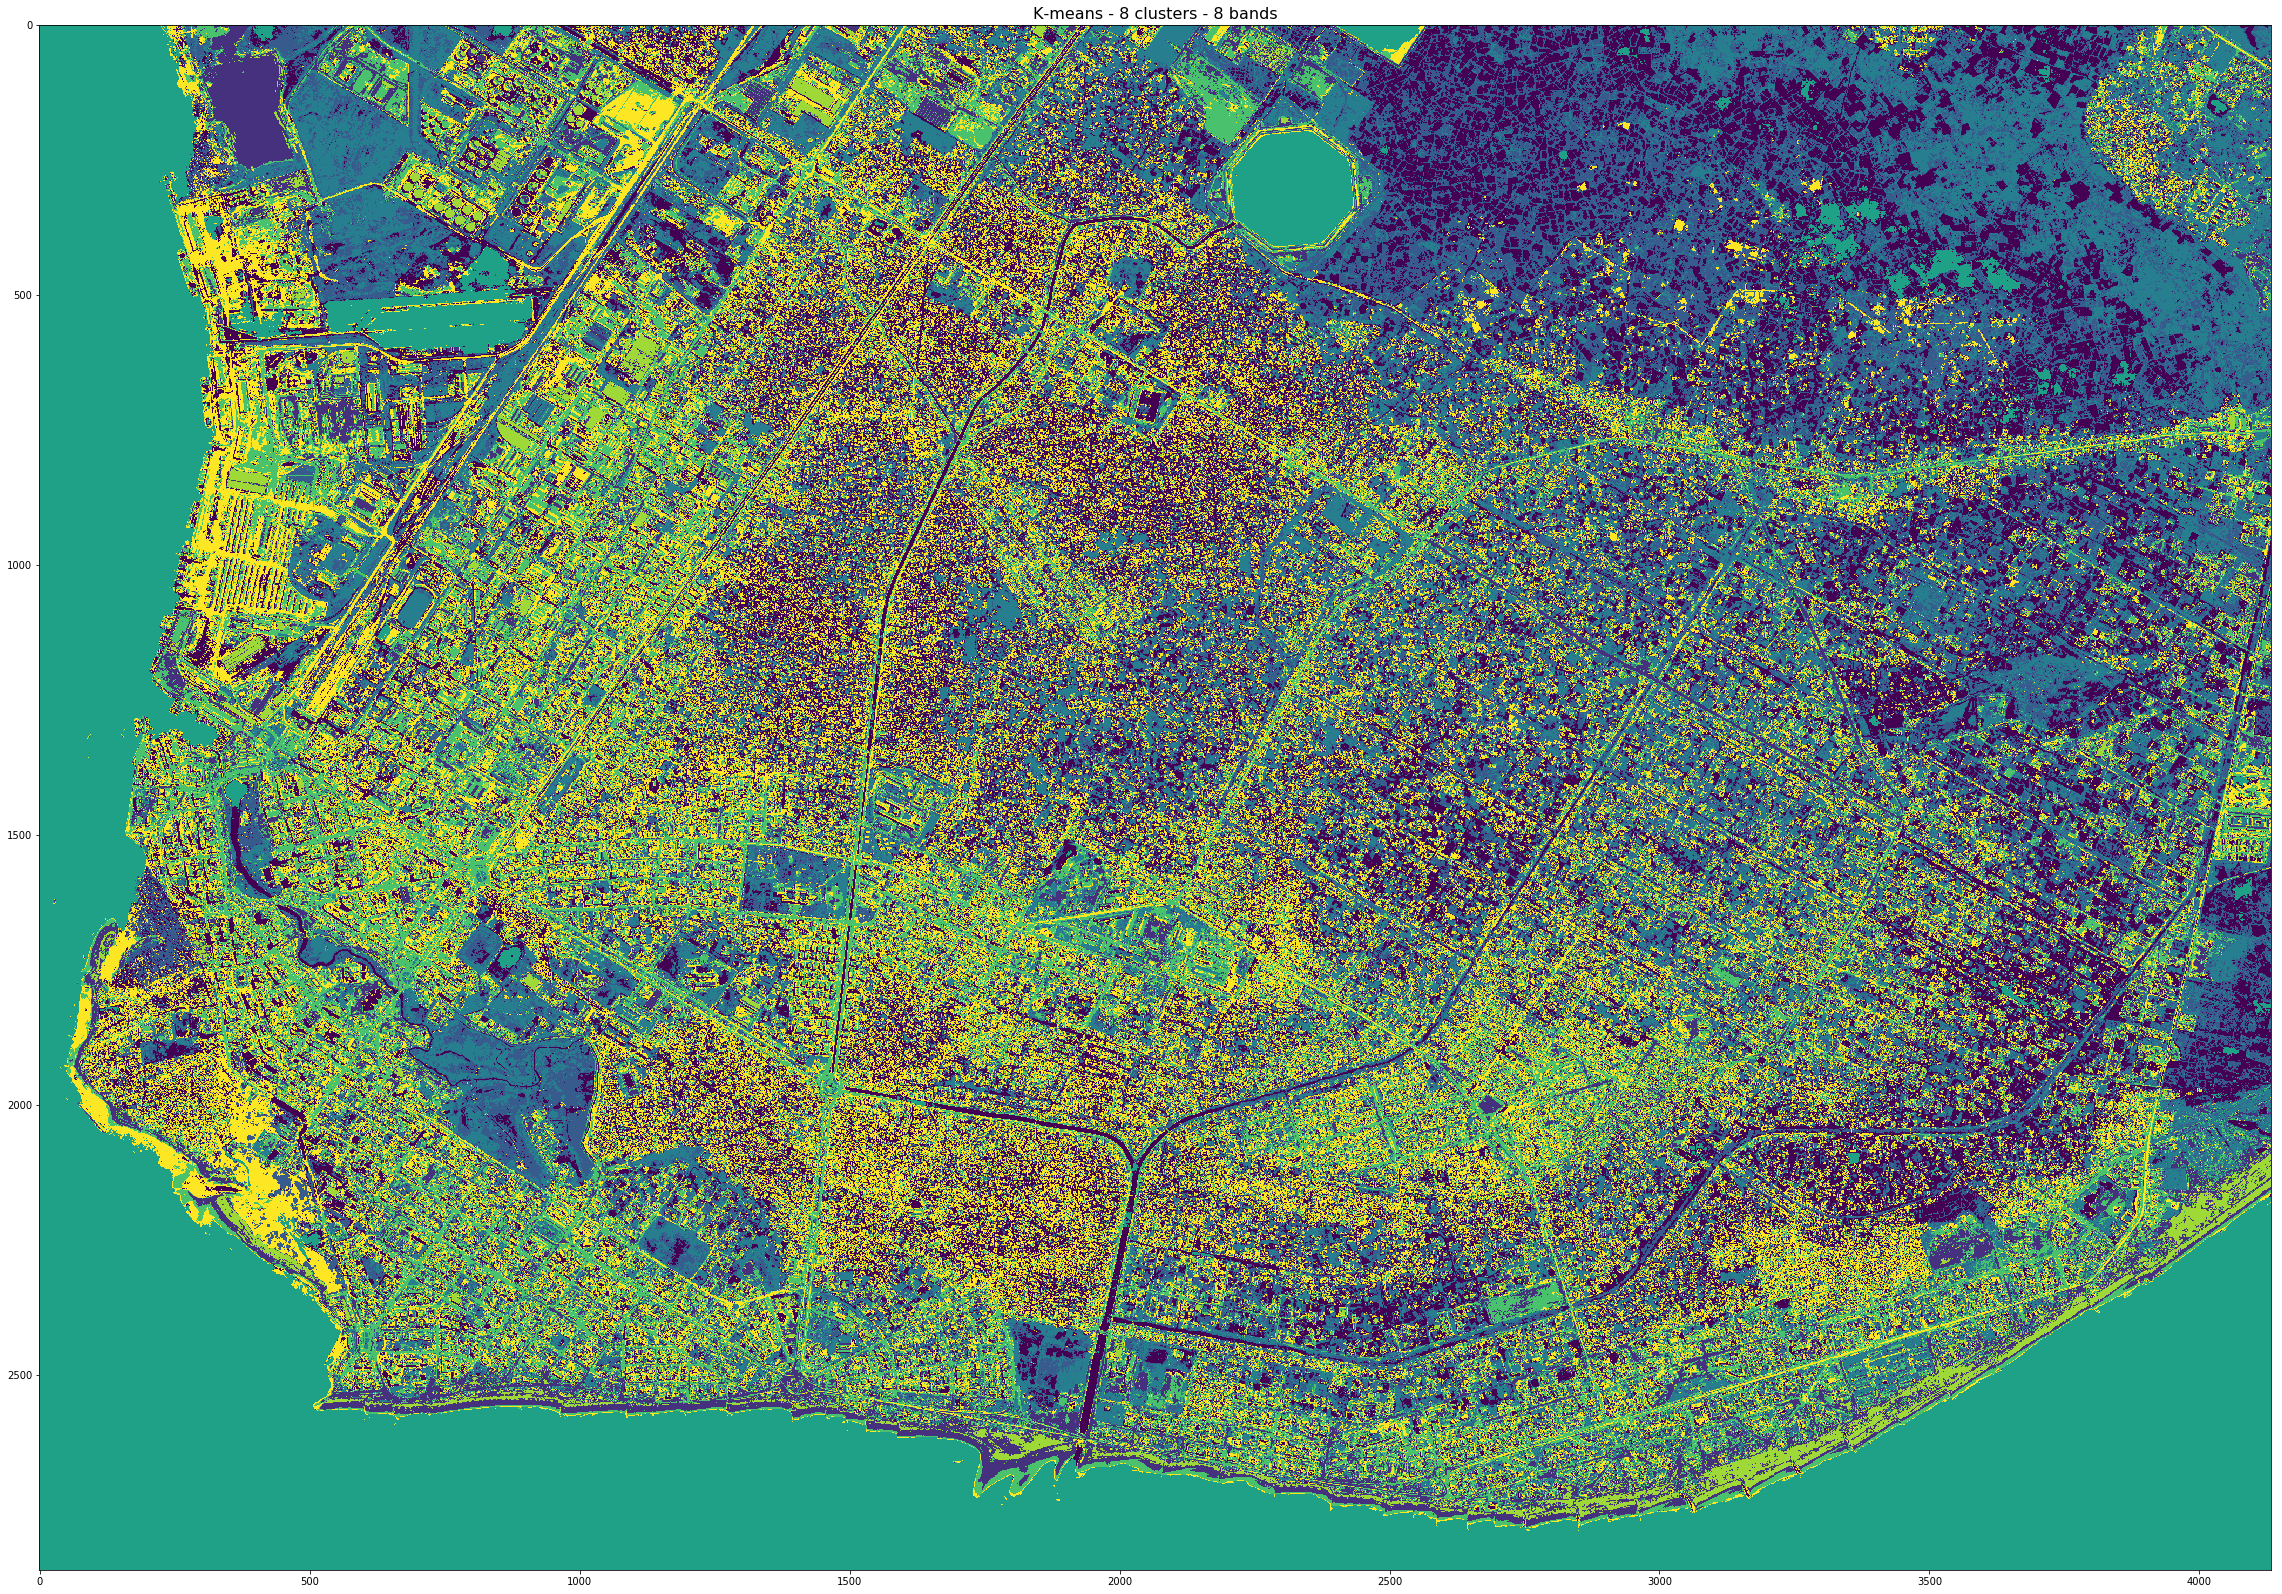

In [14]:
#Kmeans on shadow masked 8 bands plus raw values MSI
shadow_free_msi_bands_im = np.rollaxis(all_bands_shadow_free_msi, 0, 3)
X_shadow_free_msi = shadow_free_msi_bands_im .reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free_msi = clf_kmeans.fit_predict(X_shadow_free_msi, y=None)
predictedClass_shadow_free_msi += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_msi = predictedClass_shadow_free_msi.reshape(shadow_free_msi_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_msi)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]
with rio.open(kmeans_outputs_path+'kmeans_shadow_free_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_msi.astype('float32'),1)

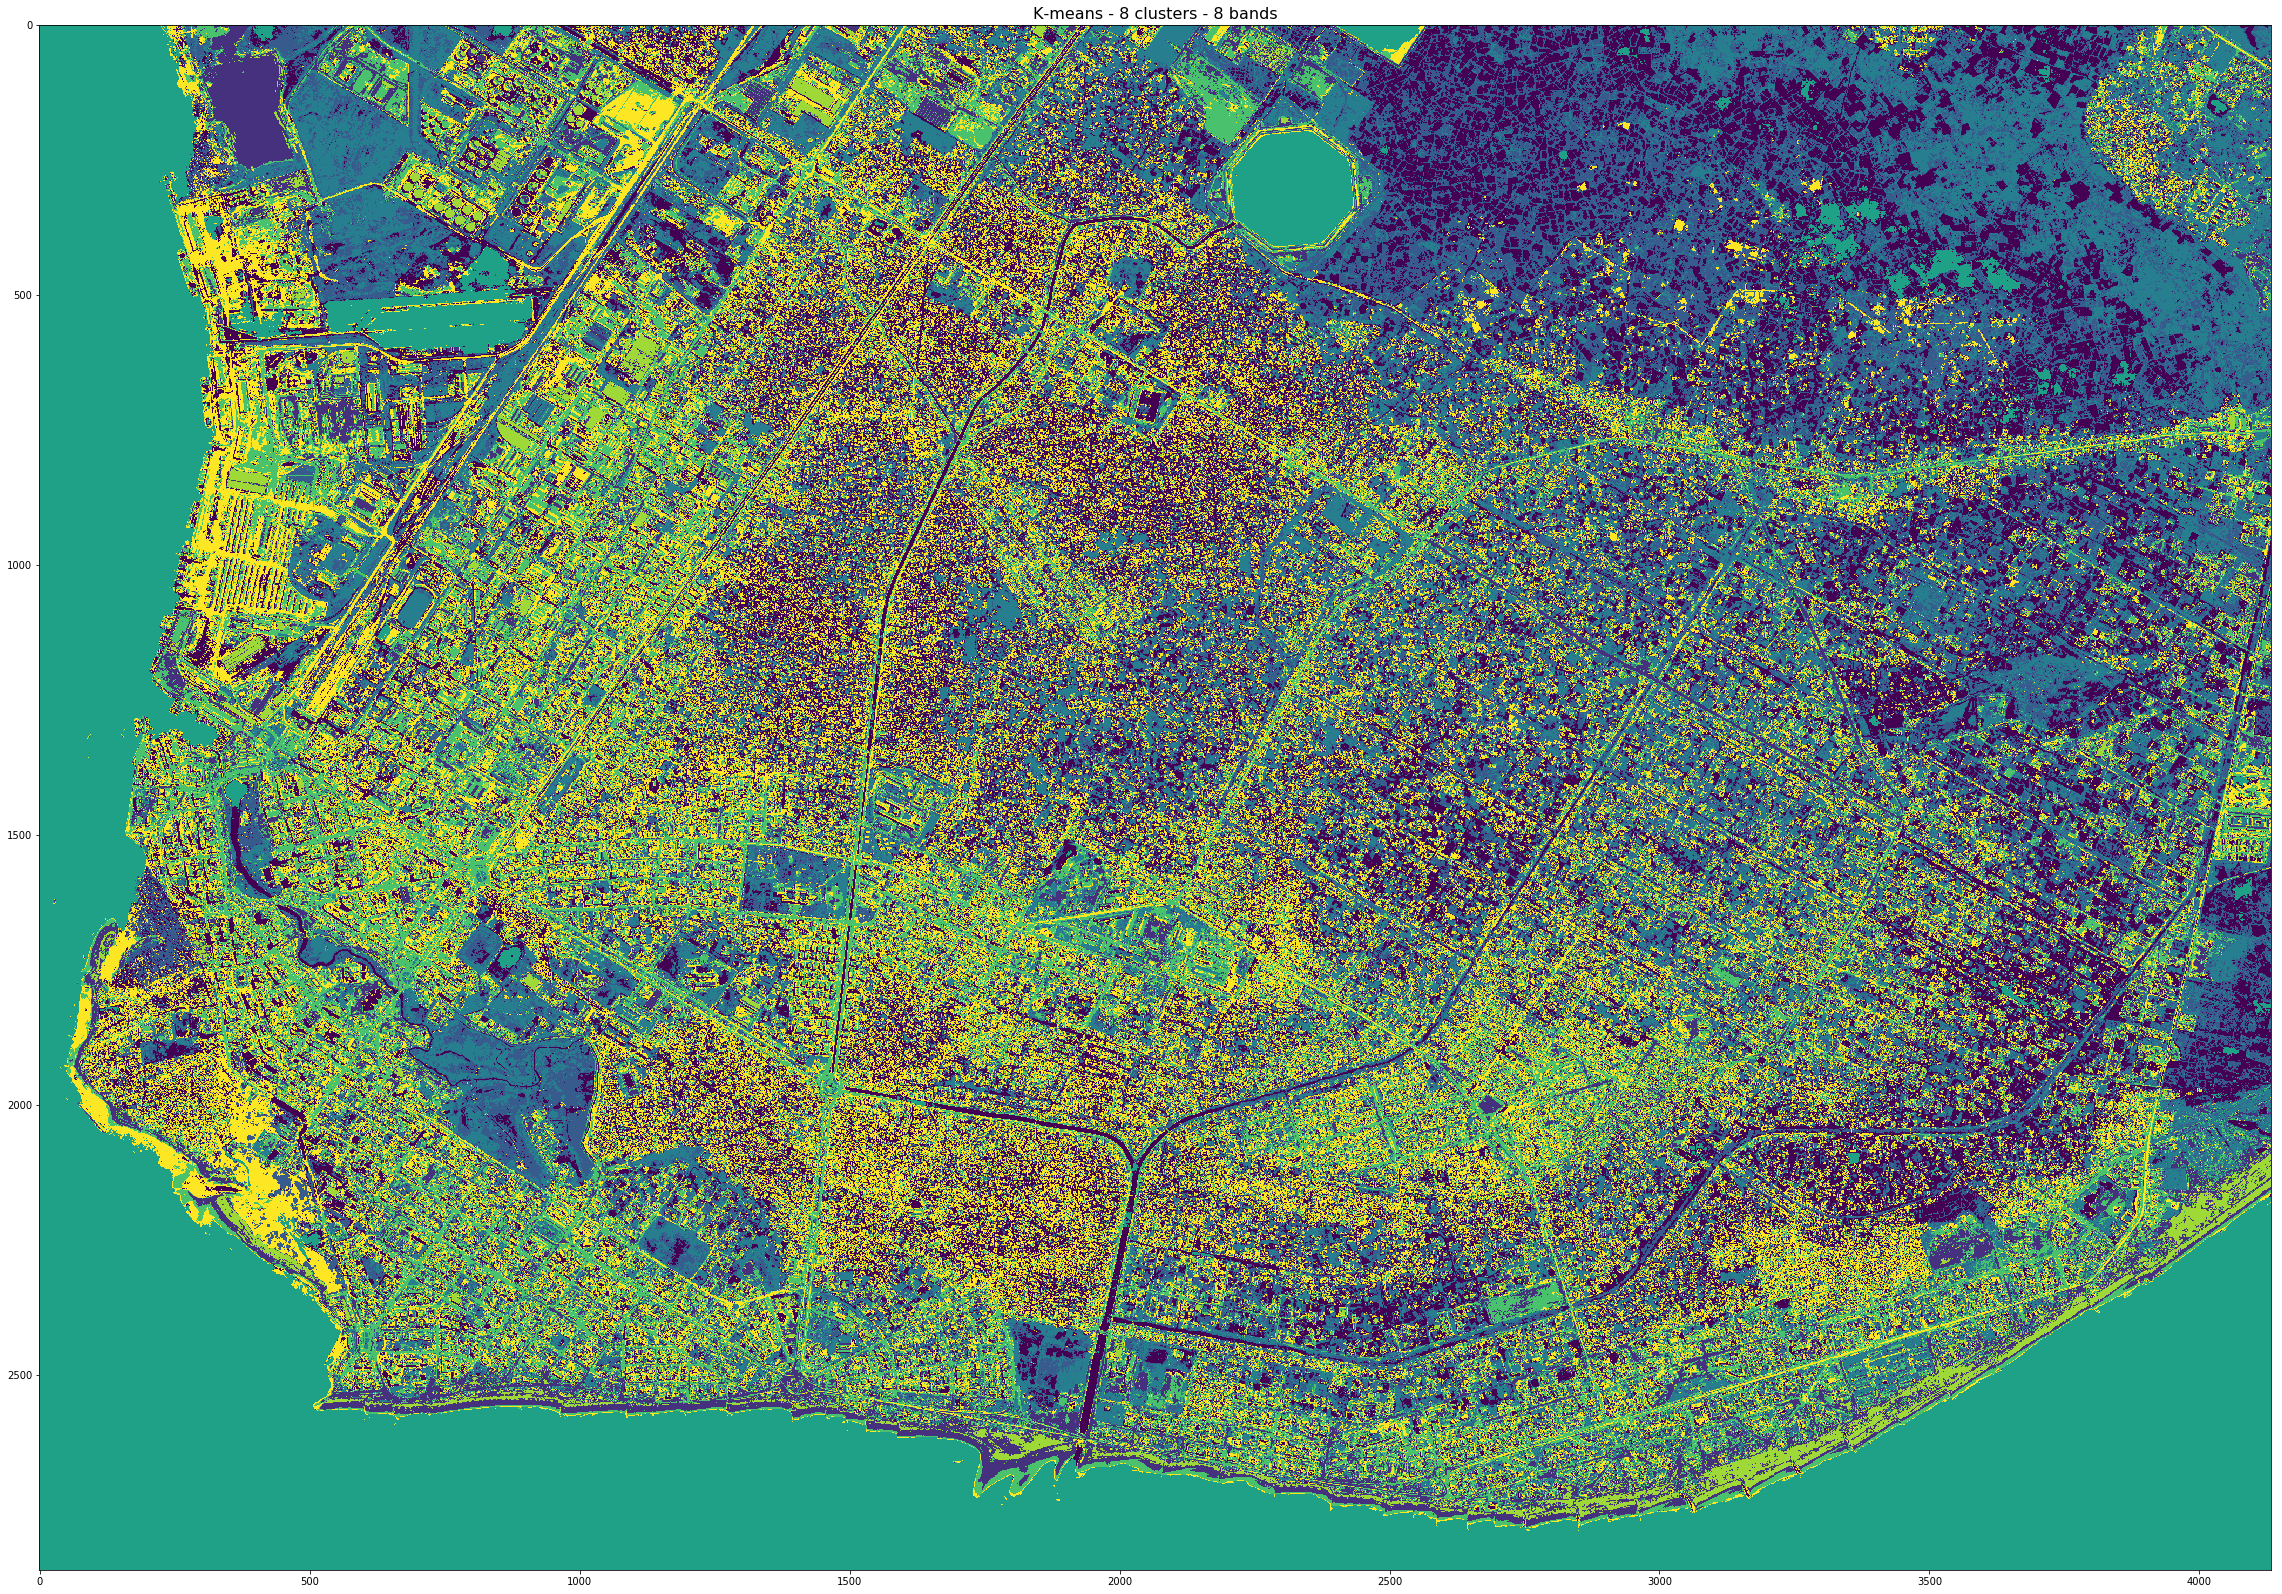

In [15]:
#Kmeans on cloud masked 8 bands plus raw values MSI
cloud_free_msi_bands_im = np.rollaxis(all_bands_cl_free_msi, 0, 3)
X_cloud_free_msi = cloud_free_msi_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free_msi = clf_kmeans.fit_predict(X_cloud_free_msi, y=None)
predictedClass_cloud_free_msi += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_cloud_free_msi = predictedClass_cloud_free_msi.reshape(cloud_free_msi_bands_im.shape[:2])
im = ax.imshow(pred_cloud_free_msi)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]
with rio.open(kmeans_outputs_path+'kmeans_cl_free_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_cloud_free_msi.astype('float32'),1)

In [ ]:
# Kmeans on shadow masked 8 bands plus shadow mask
shadow_free_shadow_mask_bands_im = np.rollaxis(all_bands_shadow_free_shadow_mask, 0, 3)
X_shadow_free_shadow_mask = shadow_free_shadow_mask_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free_shadow_mask = clf_kmeans.fit_predict(X_shadow_free_shadow_mask, y=None)
predictedClass_shadow_free_shadow_mask += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_shadow_mask = predictedClass_shadow_free_shadow_mask.reshape(shadow_free_shadow_mask_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_shadow_mask)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]
# files_out_meta['nodata']=999999
# files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
with rio.open(kmeans_outputs_path+'kmeans_shadow_free_shadow_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_shadow_mask.astype('float32'),1)

In [ ]:
# Kmeans on cloud masked 8 bands plus shadow mask
cloud_free_bands_shadow_mask_im = np.rollaxis(all_bands_cl_free_shadow_mask, 0, 3)
X_cloud_free_shadow_mask= cloud_free_bands_shadow_mask_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free_shadow_mask = clf_kmeans.fit_predict(X_cloud_free_shadow_mask, y=None)
clf_kmeans_cl_free_shadow_mask = clf_kmeans.fit(X_cloud_free_shadow_mask)
predictedClass_cloud_free_shadow_mask += 1

import earthpy.plot as ep
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_cloud_free_shadow_mask = predictedClass_cloud_free_shadow_mask.reshape(cloud_free_bands_shadow_mask_im.shape[:2])
im = ax.imshow(pred_data_cloud_free_shadow_mask)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]
# files_out_meta['nodata']=999999
# files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
with rio.open(kmeans_outputs_path+'kmeans_cl_free_shadow_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_cloud_free_shadow_mask.astype('float32'),1)

In [ ]:
# clf_kmeans_cl_free_shadow_mask = clf_kmeans.fit(X_cloud_free_shadow_mask)
# pickle.dump(clf_kmeans_cl_free_shadow_mask,open(kmeans_outputs_path+'pickle_kmeans_cl_free_shadow_mask', 'wb'))

In [ ]:
# files_out_meta['nodata']=999999
# files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
# with rio.open(kmeans_outputs_path+'kmeans_with_msi.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_shadow.astype('float32'))

## Exploring Kmeans with MBI and building mask added

In [ ]:
building_mask_stack = building_mask#[np.newaxis,:]
all_bands_shadow_free_shad_build_mask = np.vstack((all_bands_shadow_free_shadow_mask,building_mask_stack))

all_bands_shadow_free_build_mask = np.vstack((all_bands_shadow_free,building_mask_stack))

all_bands_cl_free_shad_build_mask = np.vstack((all_bands_cl_free_shadow_mask,building_mask_stack))

all_bands_cl_free_build_mask = np.vstack((all_bands_cl_free,building_mask_stack))

In [ ]:
# Kmeans with shadow and building masks
shadow_bands_shad_build_mask_im = np.rollaxis(all_bands_shadow_free_shad_build_mask, 0, 3)
X_shadow_free_shad_build_mask = shadow_bands_shad_build_mask_im.reshape(-1,10)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free_shad_build_mask = clf_kmeans.fit_predict(X_shadow_free_shad_build_mask , y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_shadow_free_shad_build_mask += 1

import earthpy.plot as ep
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_shad_build_mask = predictedClass_shadow_free_shad_build_mask.reshape(shadow_bands_shad_build_mask_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_shad_build_mask)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_shadow = pred_data_shadow_free_shad_build_mask[np.newaxis,:]

# files_out_meta['nodata']=999999
# files_out_meta['dtype']='int32'
files_out_meta['count'] = 1
with rio.open(kmeans_outputs_path+'kmeans_with_shadow_build_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_shad_build_mask.astype('float32'),1)

In [ ]:
# Kmeans with shadow and building masks 
cloud_bands_shad_build_mask_im = np.rollaxis(all_bands_cl_free_shad_build_mask, 0, 3)
X_cloud_free_shad_build_mask = cloud_bands_shad_build_mask_im.reshape(-1,10)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free_shad_build_mask= clf_kmeans.fit_predict(X_cloud_free_shad_build_mask, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_cloud_free_shad_build_mask += 1

import earthpy.plot as ep
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_cloud_bands_shad_build_mask = predictedClass_cloud_free_shad_build_mask.reshape(cloud_bands_shad_build_mask_im.shape[:2])
im = ax.imshow(pred_data_cloud_bands_shad_build_mask)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]

# files_out_meta['nodata']=999999
# files_out_meta['dtype']='int32'
files_out_meta['count'] = 1
with rio.open(kmeans_outputs_path+'kmeans_with_shadow_build_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_cloud_bands_shad_build_mask.astype('float32'),1)

In [ ]:
# # Kmeans with building mask
# shadow_bands_shadow_free_build_mask_im = np.rollaxis(all_bands_shadow_free_build_mask, 0, 3)
# X_shadow_free_build_mask = shadow_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
# predictedClass_shadow_free_build_mask = clf_kmeans.fit_predict(X_shadow_free_build_mask, y=None)

# # use the fit model
# # predictedClass = clf_pl.predict(X_pl)
# predictedClass_shadow += 1

# # Plot the result
# fig, ax = plt.subplots(figsize = (40,40))
# pred_data_shadow_free_build_mask = predictedClass_shadow_free_build_mask.reshape(shadow_bands_shadow_free_build_maskim.shape[:2])
# im = ax.imshow(pred_data_shadow_free_build_mask)
# # values = np.unique(pred_data_shadow)
# # cat_names = ["1","2","3","4","5","6","7","8"]
# # ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# # ax[1].imshow(all_bands_stack)
# plt.show()

# # pred_data_shadow = pred_data_shadow[np.newaxis,:]

# # files_out_meta['nodata']=999999
# # files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
# with rio.open(kmeans_outputs_path+'kmeans_with_build_mask.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_shadow_free_build_mask.astype('float32'),1)

In [ ]:
# # Kmeans with shadow and building masks
# cloud_bands_im = np.rollaxis(all_bands_shadow_free_build_mask, 0, 3)
# X_shadow = cloud_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
# predictedClass_shadow = clf_kmeans.fit_predict(X_shadow, y=None)

# # use the fit model
# # predictedClass = clf_pl.predict(X_pl)
# predictedClass_shadow += 1

# import earthpy.plot as ep
# ## Plot the result
# fig, ax = plt.subplots(figsize = (40,40))
# pred_data_shadow = predictedClass_shadow.reshape(shadow_bands_im.shape[:2])
# im = ax.imshow(pred_data_shadow)
# # values = np.unique(pred_data_shadow)
# # cat_names = ["1","2","3","4","5","6","7","8"]
# # ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# # ax[1].imshow(all_bands_stack)
# plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]

# # files_out_meta['nodata']=999999
# # files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
# with rio.open(kmeans_outputs_path+'kmeans_with_build_mask.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_shadow.astype('float32'))

In [ ]:
# # Adding texture band for cloud masked stack
# radius = 5
# all_bands_im = np.rollaxis(all_bands_cl_free, 0, 3)
# texture = generic_filter(all_bands_im[:,:,1], np.std, size=2*radius)
# texture_newaxis = texture[np.newaxis,:]
# bands_and_texture = np.vstack((all_bands_cl_free_shad_build_mask, texture_newaxis))
# all_bands_text_im = np.rollaxis(bands_and_texture,0,3)
# X_text = all_bands_text_im.reshape(-1,11)

# # fit the KMeans classifier to shadow and building masks stack with texture 
# predictedClass_text = clf_kmeans.fit_predict(X_text, y=None)
# # use the fit model
# # predictedClass = clf_pl.predict(X_pl)
# predictedClass_text += 1

# # Plot the result
# fig, ax = plt.subplots(figsize = (40,40))
# pred_data_shadow = predictedClass_shadow.reshape(all_bands_text_im.shape[:2])
# im = ax.imshow(pred_data_shadow)
# # values = np.unique(pred_data_shadow)
# # cat_names = ["1","2","3","4","5","6","7","8"]
# # ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# # ax[1].imshow(all_bands_stack)
# plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]

# # files_out_meta['nodata']=999999
# # files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
# with rio.open(kmeans_outputs_path+'kmeans_with_shadow_build_mask_text.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_shadow.astype('float32'))

In [ ]:
# Adding texture band for shadow free shadow masked stack
radius = 5
all_bands_im = np.rollaxis(all_bands_shadow_free_shadow_mask, 0, 3)
texture = generic_filter(all_bands_im[:,:,1], np.std, size=2*radius)
texture_newaxis = texture[np.newaxis,:]
bands_and_texture = np.vstack((all_bands_shadow_free_shadow_mask, texture_newaxis))
all_bands_text_im = np.rollaxis(bands_and_texture,0,3)
X_text = all_bands_text_im.reshape(-1,10)

# fit the KMeans classifier to shadow and building masks stack with texture 
predictedClass_text = clf_kmeans.fit_predict(X_text, y=None)
# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_text += 1

import earthpy.plot as ep
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow = predictedClass_text.reshape(all_bands_text_im.shape[:2])
im = ax.imshow(pred_data_shadow)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]

# files_out_meta['nodata']=999999
# files_out_meta['dtype']='int32'
files_out_meta['count'] = 1
with rio.open(kmeans_outputs_path+'kmeans_with_shadow_free_shadow_masked_texture.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow.astype('float32'),1)

#  Try GMM

In [ ]:
from sklearn.mixture import GaussianMixture
clf_gm = GaussianMixture(n_components=8)#.fit(X_ps).predict(X_ps)

In [ ]:
# Fit the GMM classifier to the 8-band stack
predictedClass_gm = clf_gm.fit_predict(X_all_bands_stack, y=None)
predictedClass_gm += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_gm = predictedClass_gm.reshape(all_bands_im.shape[:2])
ax.imshow(pred_data_gm)
# ax[1].imshow(bytescale(all_bands_stack))
plt.show()
with rio.open(outputs_path+'gmm_all_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_gm.astype('float32'),1)

In [ ]:
# Fit the GMM classifier to the 8-band cloud free stack
predictedClass_gm = clf_gm.fit_predict(X_cloud_free, y=None)
predictedClass_gm += 1


## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_gm = predictedClass_gm.reshape(cloud_free_bands_im.shape[:2])
ax.imshow(pred_data_gm)
plt.show()

# Write out tif
with rio.open(outputs_path+'gmm_cl_free_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_gm.astype('float32'),1)

In [ ]:
# Fit the GMM classifier to the 8-band shadow free stack
predictedClass_shadow_free_gmm = clf_gm.fit_predict(X_shadow_free, y=None)
predictedClass_shadow_free_gmm += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_shadow_free_gmm = predictedClass_shadow_free_gmm.reshape(shadow_free_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_gmm)
plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
plt.show()

# Write out tif
with rio.open(kmeans_outputs_path+'gmm_shadow_free.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_gmm.astype('float32'),1)

In [ ]:
# Fit the GMM classifier to the 8-band shadow free stack plus shadow mask
predictedClass_shadow_free_shadow_mask_gmm = clf_gm.fit_predict(X_shadow_free_shadow_mask, y=None)
predictedClass_shadow_free_shadow_mask_gmm += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_shadow_mask_gmm = predictedClass_shadow_free_shadow_mask_gmm.reshape(shadow_free_shadow_mask_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_shadow_mask_gmm)
plt.title("K-means - 8 clusters - 8 bands")

plt.show()

with rio.open(kmeans_outputs_path+'gmm_shadow_free_shadow_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_shadow_mask_gmm.astype('float32'),1)

In [ ]:
# Develop building mask for MBI > threshold and apply morphological opening
from skimage.morphology import opening, disk

building = (mbi>=0.065).astype(int)
selem_building = disk(1)
building_opened = opening(building, selem_building)

In [ ]:
# Plot vegetation and building masks
fig, ax = plt.subplots(figsize=(20,10))

ndvi_plot = ax.imshow(vegetation_mask==1, cmap = 'Greens')
mbi_plot = ax.imshow(building_mask==1, cmap='Greys',alpha = 0.6)
flood_plot = ax.imshow(flood_mask==1, cmap='Blues', alpha=0.5)
msi_plot = ax.imshow(shadow_mask==1, cmap='Reds',alpha=0.5)

ax.set(title="Veg, Shadow, Flood and Building Masks\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

## Attempts at combining masks into a single image. 
Hierarchy is as follows:
Shadow_mask, flood_mask, veg_mask, building_mask

Which means..
values of 5, 10, 15, 20, 30, 60, 120 --> 5 (shadow)
values of 4, 8, 12, 24 --> 4 (water)
values of 3, 6 --> 3 (vegetation)
values of 2 --> 2 (building)

# Swapped in NDWI_yellow for "flood mask" from cloud to street
Improved accuracy score
original was flood_mask_comb = flood_mask*4

In [ ]:
shadow_mask_comb = shadow_mask*5
flood_mask_comb = ndwi_yellow_mask*4
veg_mask_comb = vegetation_mask*3
building_mask_comb = building_mask*2
index_comb = shadow_mask_comb*flood_mask_comb*veg_mask_comb*building_mask_comb
np.unique(building_mask_comb)

In [ ]:
shadow_mask_comb = np.where(shadow_mask_comb==0,1,shadow_mask_comb)
flood_mask_comb = np.ma.where(flood_mask_comb==0,1,flood_mask_comb)
veg_mask_comb = np.where(veg_mask_comb==0,1,veg_mask_comb)
building_mask_comb = np.where(building_mask_comb==0,1,building_mask_comb)
index_comb = shadow_mask_comb*flood_mask_comb*veg_mask_comb*building_mask_comb
np.unique(index_comb)

In [ ]:
index_comb = np.where(index_comb>=30,5,index_comb)
index_comb = np.where(index_comb==10,5,index_comb)
index_comb = np.where(index_comb==15,5,index_comb)
index_comb = np.where(index_comb==20,5,index_comb)
index_comb = np.where(index_comb==24,4,index_comb)
index_comb = np.where(index_comb==12,4,index_comb)
index_comb = np.where(index_comb==8,2,index_comb)
index_comb = np.where(index_comb==6,3,index_comb)
index_comb

In [ ]:
from matplotlib.colors import ListedColormap
# Plot combined masks
fig,ax = plt.subplots(figsize=(20,10))
cmap = ListedColormap(['white','grey','darkseagreen','royalblue','m'])
ax.imshow(index_comb, cmap = cmap)
ax.set(title="Combined Masks\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

# Calculate flooded surface area

In [ ]:
no_data_pix = (index_comb==1).sum()
building_pix = (index_comb==2).sum()
veg_pix = (index_comb==3).sum()
flood_pix = (index_comb==4).sum()
shadow_pix = (index_comb==5).sum()

res = 0.46*0.46
flood_area = flood_pix*res
flood_area

In [ ]:
threshold_outputs_path = os.path.join(band_path, "outputs\\threshold\\")
try:
    os.makedirs(threshold_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")
with rio.open(threshold_outputs_path+'index_comb_yellow.tif', 'w', **files_out_meta) as dst:
    dst.write(index_comb.astype('float32'), 1)

In [ ]:
import geopandas as gpd
import pandas as pd
# Sample reference points
# sample_pts_path = os.path.join('C:\\Users\\katy\\earth-analytics\\spring-2019\\flood-detection\\validation\\')
validation_data_path = os.path.join(band_path,'validation\\')

sample_pts_60perc = gpd.read_file(validation_data_path+"vector-data\\"+"validation_points_koumassi_60_percent.shp")
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_60perc.geometry.x)
y_coords = tuple(sample_pts_60perc.geometry.y)

index_comb_path = threshold_outputs_path+"index_comb_yellow.tif"
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(index_comb_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
index_comb_60perc_df = pd.DataFrame(arr)
index_comb_60perc_df.head()
np.unique(index_comb_60perc_df)
# valid_data_path = os.path.join("C:\\Users\\katy\\earth-analytics\\spring-2019\\flood-detection\\validation\\")
valid_60_data = pd.read_csv(validation_data_path+"\\"+"koumassi_validation_data_60_percent.csv")
valid_60_data

# Merge 
# accuracy_threshold = [[valid_data,index_comb['Land_Cover_Class']]]
# pieces = [valid_data[:], index_comb_df['0']]
# index_comb_df

# index_comb_df.columns = "Land_Cover_Class"
# index_comb_df.rename(columns={'0':'population'}, inplace=True)
index_comb_60perc_df.columns=["Land_Cover_Class"]


# accuracy_threshold = [[valid_data['ClassValue'],index_comb['Land_Cover_Class']]]
accuracy_threshold = pd.concat([valid_60_data,index_comb_60perc_df], axis=1, sort=False)
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class'] == 5.0,"new"] = 1
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class'] == 4.0,"new"] = 2
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class'] == 3.0,"new"] = 3
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class'] == 2.0,"new"] = 3
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class'] == 1.0,"new"] = 3

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
ytest_60perc = accuracy_threshold['ClassValue']
ypred_60perc = accuracy_threshold['new']
accuracy_score(ytest_60perc, ypred_60perc)

Using NDWI_yellow vs. flood_mask increases accuracy score by 8%

In [ ]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest_60perc, ypred_60perc))

plt.imshow(confusion_matrix(ytest_60perc, ypred_60perc),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
# Accuracy score for 40% external validation data
import geopandas as gpd
import pandas as pd
# Sample reference points
# sample_pts_path = os.path.join('C:\\Users\\katy\\earth-analytics\\spring-2019\\flood-detection\\validation\\')
sample_pts_40perc = gpd.read_file(validation_data_path+"vector-data\\"+"validation_points_koumassi_40_percent.shp")
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_40perc.geometry.x)
y_coords = tuple(sample_pts_40perc.geometry.y)

# index_comb_path = threshold_outputs_path+"index_comb_yellow.tif"
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(index_comb_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
index_comb_40perc_df = pd.DataFrame(arr)
index_comb_40perc_df.columns=["Land_Cover_Class"]

index_comb_40perc_df.head()
# np.unique(all_index_comb_df)

In [ ]:
# valid_40_data_path = os.path.join("C:\\Users\\katy\\earth-analytics\\spring-2019\\flood-detection\\validation\\")
valid_40_data = pd.read_csv(validation_data_path+"koumassi_validation_data_40_percent.csv")
accuracy_40_threshold = pd.concat([valid_40_data,index_comb_40perc_df], axis=1, sort=False)

In [ ]:
# accuracy_threshold = [[valid_data['ClassValue'],index_comb['Land_Cover_Class']]]
accuracy_40_threshold.loc[accuracy_40_threshold['Land_Cover_Class'] == 5.0,"new"] = 1
accuracy_40_threshold.loc[accuracy_40_threshold['Land_Cover_Class'] == 4.0,"new"] = 2
accuracy_40_threshold.loc[accuracy_40_threshold['Land_Cover_Class'] == 3.0,"new"] = 3
accuracy_40_threshold.loc[accuracy_40_threshold['Land_Cover_Class'] == 2.0,"new"] = 3
accuracy_40_threshold.loc[accuracy_40_threshold['Land_Cover_Class'] == 1.0,"new"] = 3

In [ ]:
ytest_40 = accuracy_40_threshold['ClassValue']
ypred_40 = accuracy_40_threshold['new']
accuracy_score(ytest_40, ypred_40)

In [ ]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest_40, ypred_40))

plt.imshow(confusion_matrix(ytest_40, ypred_40),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
# Accuracy score for all validation points
import geopandas as gpd
import pandas as pd
# Sample reference points
# sample_pts_path = os.path.join('C:\\Users\\katy\\earth-analytics\\spring-2019\\flood-detection\\validation\\')
sample_pts_all = gpd.read_file(validation_data_path+"vector-data\\"+"all_koumassi_validation_points.shp")
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_all.geometry.x)
y_coords = tuple(sample_pts_all.geometry.y)

# index_comb_path = outputs_path+"index_comb_yellow.tif"
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(index_comb_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
index_comb_all_df = pd.DataFrame(arr)
index_comb_all_df.columns=["Land_Cover_Class"]

index_comb_all_df.head()
np.unique(index_comb_all_df)

In [ ]:
# all_valid_data_path = os.path.join("C:\\Users\\katy\\earth-analytics\\spring-2019\\flood-detection\\validation\\")
all_valid_data = pd.read_csv(validation_data_path+"all_koumassi_validation_data.csv")
all_data_accuracy_threshold = pd.concat([all_valid_data,index_comb_all_df], axis=1, sort=False)

In [ ]:
# accuracy_threshold = [[valid_data['ClassValue'],index_comb['Land_Cover_Class']]]
all_data_accuracy_threshold.loc[all_data_accuracy_threshold['Land_Cover_Class'] == 5.0,"new"] = 1
all_data_accuracy_threshold.loc[all_data_accuracy_threshold['Land_Cover_Class'] == 4.0,"new"] = 2
all_data_accuracy_threshold.loc[all_data_accuracy_threshold['Land_Cover_Class'] == 3.0,"new"] = 3
all_data_accuracy_threshold.loc[all_data_accuracy_threshold['Land_Cover_Class'] == 2.0,"new"] = 3
all_data_accuracy_threshold.loc[all_data_accuracy_threshold['Land_Cover_Class'] == 1.0,"new"] = 3

In [ ]:
ytest_all = all_data_accuracy_threshold['ClassValue']
ypred_all = all_data_accuracy_threshold['new']
accuracy_score(ytest_all, ypred_all)

In [ ]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest_all, ypred_all))

plt.imshow(confusion_matrix(ytest_all, ypred_all),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

### Check if index_comb_yellow is the right file

Trial using SDI from Shahi et al. 2014. *A Novel Spectral Index for Automatic Shadow Detection in Urban Mapping Based On  WorldView-2 Satellite Imagery.* World Academy of Science, Engineering and Technology International Journal of Environmental and Ecological Engineering Vol:8, No:10.

In [ ]:
sdi = ((nearir2_scaled-blue_cl_free)/(nearir2_cl_free+blue_cl_free))-nearir1_cl_free
print(sdi.max())

In [ ]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(sdi.ravel());

In [ ]:
# Plot SDI
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(sdi>0.15, cmap='Spectral',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="SDI\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

Appears to catch vegetation with the shadow.

In [ ]:
# Develop shadow mask for SDI and apply morphological opening to remove noise
sdi_mask = morph_indices.smooth_disk(index_array=sdi,threshold=0.15,disk_size=4)

# Plot SDI mask
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(sdi_mask, cmap='Oranges',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="SDI Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
flood_sdi = ndwi_green-sdi
# Plot ndwi_green - sdi
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(flood_sdi>0, cmap='Blues',
                vmin=-1, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="NDWI_Green - SDI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
ndwi_green_sdi_mask_smoothed = morph_indices.smooth_disk(index_array=flood_sdi,threshold=0.25,disk_size=4)
# Plot SDI mask
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(ndwi_green_sdi_mask_smoothed, cmap='Blues',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="NDWI_Green SDI Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
dark = dark[np.newaxis,:]
msi = msi[np.newaxis,:]
mbi = mbi[np.newaxis,:]
ndwi_coastal_msi = ndwi_coastal_msi[np.newaxis,:]
ndwi_green_msi = ndwi_green_msi[np.newaxis,:]

stack = [dark,msi,mbi,ndwi_coastal_msi,ndwi_green_msi]
feature_stack = np.vstack(stack)
feature_stack.shape
stack_im = np.rollaxis(feature_stack, 0, 3)
feature_image = stack_im.reshape(-1,5)
feature_image

In [ ]:
ndwi_green_msi

In [ ]:
# Kmeans on "cleaned" shadow mask.. did not show great results
# shadow_bands_im = np.rollaxis(all_bands_shadow_free_shadow_mask_cleaned, 0, 3)
# X_shadow = shadow_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
# predictedClass_shadow = clf_kmeans.fit_predict(X_shadow, y=None)

# # use the fit model
# # predictedClass = clf_pl.predict(X_pl)
# predictedClass_shadow += 1

# import earthpy.plot as ep
# ## Plot the result
# fig, ax = plt.subplots(figsize = (40,40))
# pred_data_shadow = predictedClass_shadow.reshape(shadow_bands_im.shape[:2])
# im = ax.imshow(pred_data_shadow)
# values = np.unique(pred_data_shadow)
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# # ax[1].imshow(all_bands_stack)
# plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]

# # files_out_meta['nodata']=999999
# # files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
# with rio.open(outputs_path+'kmeans_with_shadow_mask_cleaned.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_shadow.astype('float32'))

In [ ]:
# # Kmeans on all  bands plus smoothed MSI
# shadow_bands_im = np.rollaxis(all_bands_shadow_free_smoothed_msi, 0, 3)
# X_shadow = shadow_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
# predictedClass_shadow = clf_kmeans.fit_predict(X_shadow, y=None)

# # use the fit model
# # predictedClass = clf_pl.predict(X_pl)
# predictedClass_shadow += 1

# import earthpy.plot as ep
# ## Plot the result
# fig, ax = plt.subplots(figsize = (40,40))
# pred_data_shadow = predictedClass_shadow.reshape(shadow_bands_im.shape[:2])
# im = ax.imshow(pred_data_shadow)
# # values = np.unique(pred_data_shadow)
# # cat_names = ["1","2","3","4","5","6","7","8"]
# # ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
# # ax[1].imshow(all_bands_stack)
# plt.show()

# pred_data_shadow = pred_data_shadow[np.newaxis,:]

# # files_out_meta['nodata']=999999
# # files_out_meta['dtype']='int32'
# files_out_meta['count'] = 1
# with rio.open(kmeans_outputs_path+'kmeans_with_smoothed_msi.tif', 'w', **files_out_meta) as dst:
#     dst.write(pred_data_shadow.astype('float32'))

In [ ]:
# # NEW
# # Define aoi 
# aoi = "koumassi_focus_ps"

# # Set paths
# kmeans_file ="kmeans_with_shadow_mask"
# band_path = '..\\data\\'+aoi+"\\"
# raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")
# kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
# kmeans_path = os.path.join(band_path, "outputs\\kmeans\\"+kmeans_file+".tif")

# # Read in validation reference point shape files
# validation_data_path = os.path.join(band_path,'validation\\')
# sample_pts_60perc = gpd.read_file(validation_data_path+"vector-data\\additional_validation_points_60perc.shp")
# sample_pts_40perc = gpd.read_file(validation_data_path+"vector-data\\additional_validation_points_40perc.shp")
# sample_pts_all = gpd.read_file(validation_data_path+"vector-data\\"+"additional_validation_points.shp")

# # Read in all validation data for 60%, 40% and all data sets
# valid_60_data = pd.read_csv(validation_data_path+"additional_validation_points_60perc.csv")
# valid_40_data = pd.read_csv(validation_data_path+"additional_validation_points_40perc.csv")
# all_valid_data = pd.read_csv(validation_data_path+"additional_validation_points.csv")

In [ ]:
# # Update classes after confirming at what each cluster represents
# # 1 = shadow, 2 = flood, 3 = other
# class8 = 2
# class7 = 3 # used 1 here for shadow_build
# class6 = 3
# class5 = 1
# class4 = 3
# class3 = 1 # see what validates better 1 or 2
# class2 = 3 # choose 1 or 2 for 010
# class1 = 3